
# Comparing spectral connectivity computed over time or over trials

This example demonstrates the difference between spectral connectivity
computed over time or over trials.

A brief background on the difference between the two conditions is provided,
followed by examples on simulated data and real EEG data.


## Background

Spectral connectivity is a method for inferring the relationship between
channels decomposed at different frequencies of interest. The channels
could be M/EEG sensors or brain regions estimated with source localization.

There are multiple different spectral connectivity measures, e.g. coherence,
imaginary part of coherence, phase locking value, and envelope correlations.
Additionally, there are also multiple methods to estimate the frequency
content, e.g. Fourier transforms, Morlet wavelets and multitapers.

In this example, we focus on the two functions, which both computes
connectivity from epoched data :class:`mne.Epochs`:
:func:`mne_connectivity.spectral_connectivity_epochs` and
:func:`mne_connectivity.spectral_connectivity_time`.

Both functions contain the options to choose the connectivity measurements
of interest and the method to decompose the frequency content.
The crucial difference between when to use which function lies on
the experimental setup and type of tasks.

If the data is obtained for repeated trials of a time-locked event,
e.g. [ERP](erp_tut_) data, then
:func:`mne_connectivity.spectral_connectivity_epochs`
is most likely the corresponding function to utilize.


If the data is obtained from resting-state or free-moving tasks,
e.g. a mirror-game paradigm :footcite:`Zimmermann2022`, then
:func:`mne_connectivity.spectral_connectivity_time` might be better suited.

**Assumptions and Interpretations**

The way connectivity is computed for the two functions are slightly
different, thus their interpretations and the hypotheses being tested are
also different.

Connectivity over trials, as computed by
:func:`mne_connectivity.spectral_connectivity_epochs` assume epochs have
been created around each trial and the function estimates the connectivity
at each timepoint over all the repeated trials for the same event.
This gives a high temporal resolution, which is often desired for ERP
analysis where you are interested in when an effect occurs.
However, this approach is not feasible for single-trial data and will
result in errorful values when computed on one epoch.

On the other hand, if you are interested in determining connectivity over
time for single-trials or from experiments that do not involve exactly
repeated trials, then :func:`mne_connectivity.spectral_connectivity_time`
should be employed. This function also takes data in the form of
:class:`mne.Epochs`, but it may consist of a single epoch.
If there are multiple epochs, the connectivity over time is computed for
epoch separately, with the option to average over epochs.

To better illustrate the differences and usages for the two functions,
we will employ them on two simulated cases and also analyze a real
visual task dataset.



In [1]:
# Author: Qianliang Li <glia@dtu.dk>
#
# License: BSD (3-clause)

import numpy as np
import matplotlib.pyplot as plt
import mne

from mne_connectivity import spectral_connectivity_epochs, spectral_connectivity_time
from mne_connectivity.viz import plot_sensors_connectivity
from mne.datasets import sample

rng = np.random.default_rng(1234)  # set seed for reproducibility

print(__doc__)

Automatically created module for IPython interactive environment


## Simulated examples
**Case 1: Repetitions of the same trial.**

Let's generate some simulated data in the format of :class:`mne.EpochsArray`.
In this case, we will use random data for 3 channels over 5 epochs, but
all the epochs are just exact replicates of the first epoch. This simulates
when data is collected over an event of interest where we **assume** the
connectivity structure is the same over each event.



In [2]:
n_epochs = 5  # number of simulated epochs
n_channels = 3  # number of channels
n_times = 2000  # number of sample points
sfreq = 250  # Set sampling freq
data = rng.random((n_epochs, n_channels, n_times))  # generate random data

# In case 1, we overwrite all epochs with the data from the first epoch
for i in range(n_epochs):
    data[i] = data[0]

ch_names = ["C3", "Cz", "C4"]  # three random channel names
info = mne.create_info(ch_names, sfreq, ch_types="eeg")  # create info object
data_epoch = mne.EpochsArray(data, info)  # create EpochsArray

data_epoch.plot(scalings=0.75)  # Visualize the data

Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using qt as 2D backend.


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-wanglab'


First we compute connectivity over trials.



In [3]:
# Freq bands of interest
Freq_Bands = {"theta": [4.0, 8.0], "alpha": [8.0, 13.0], "beta": [13.0, 30.0]}
n_freq_bands = len(Freq_Bands)
min_freq = np.min(list(Freq_Bands.values()))
max_freq = np.max(list(Freq_Bands.values()))

# Provide the freq points
freqs = np.linspace(min_freq, max_freq, int((max_freq - min_freq) * 4 + 1))

# The dictionary with frequencies are converted to tuples for the function
fmin = tuple([list(Freq_Bands.values())[f][0] for f in range(len(Freq_Bands))])
fmax = tuple([list(Freq_Bands.values())[f][1] for f in range(len(Freq_Bands))])

# We will try two different connectivity measurements as an example
connectivity_methods = ["coh", "plv"]
n_con_methods = len(connectivity_methods)

# Pre-allocatate memory for the connectivity matrices
con_epochs_array = np.zeros(
    (n_con_methods, n_channels, n_channels, n_freq_bands, n_times)
)
con_epochs_array[con_epochs_array == 0] = np.nan  # nan matrix

# Compute connectivity over trials
con_epochs = spectral_connectivity_epochs(
    data_epoch,
    method=connectivity_methods,
    sfreq=sfreq,
    mode="cwt_morlet",
    cwt_freqs=freqs,
    fmin=fmin,
    fmax=fmax,
    faverage=True,
)

# Get data as connectivity matrices
for c in range(n_con_methods):
    con_epochs_array[c] = con_epochs[c].get_data(output="dense")

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 3 connections
    using t=0.000s..7.996s for estimation (2000 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..8.0Hz (17 points)
     band 2: 8.0Hz..13.0Hz (21 points)
     band 3: 13.0Hz..30.0Hz (69 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence, PLV
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3


/tmp/ipykernel_71245/2149493585.py:25: RuntimeWarning: There were no Annotations stored in <EpochsArray |  5 events (all good), 0 – 7.996 s, baseline off, ~242 kB, data loaded,
 '1': 5>, so metadata was not modified.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    assembling connectivity matrix
[Connectivity computation done]


As previously mentioned, connectivity over trials can give connectivity
for each timepoint, here in the form of
:class:`mne_connectivity.SpectroTemporalConnectivity`.
However, in this example we are not interested in the timing, so we will
average over all timepoints. Notice that only ``mode="cwt_morlet"`` will
return an instance of :class:`mne_connectivity.SpectroTemporalConnectivity`
and ``mode="fourier"`` or ``mode="multitaper"`` returns an instance of
:class:`mne_connectivity.SpectralConnectivity`, which does not have
single timepoint resolution.



Connectivity method: coh
[[0. 0. 0.]
 [1. 0. 0.]
 [1. 1. 0.]]
Connectivity method: plv
[[0. 0. 0.]
 [1. 0. 0.]
 [1. 1. 0.]]


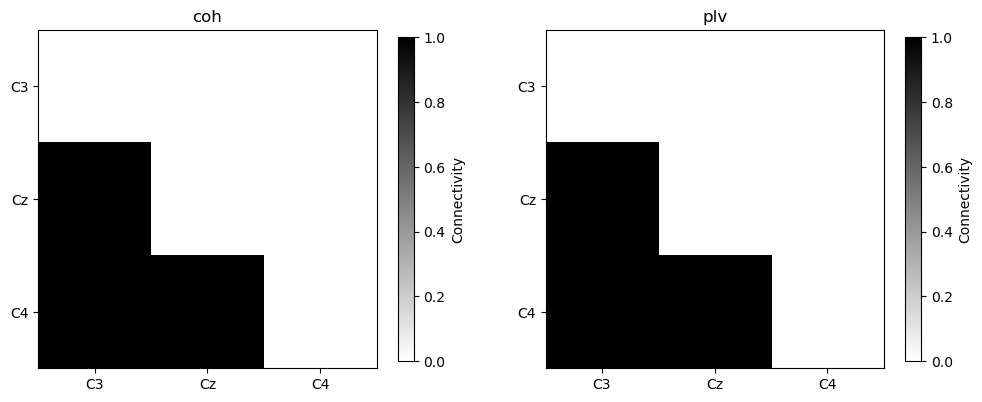

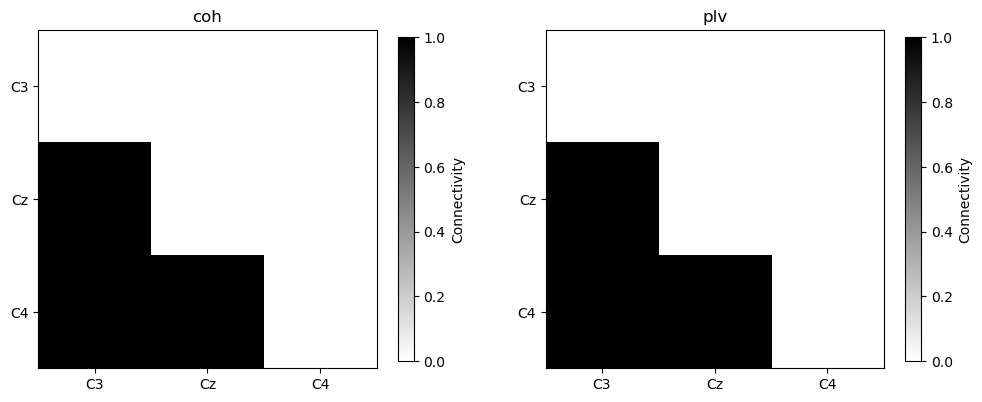

In [4]:
con_epochs_array = np.mean(con_epochs_array, axis=4)  # average over timepoints

# In this example, we will just show alpha
foi = list(Freq_Bands.keys()).index("alpha")  # frequency of interest


# Define function for plotting con matrices
def plot_con_matrix(con_data, n_con_methods):
    """Visualize the connectivity matrix."""
    fig, ax = plt.subplots(1, n_con_methods, figsize=(6 * n_con_methods, 6))
    for c in range(n_con_methods):
        # Plot with imshow
        con_plot = ax[c].imshow(con_data[c, :, :, foi], cmap="binary", vmin=0, vmax=1)
        # Set title
        ax[c].set_title(connectivity_methods[c])
        # Add colorbar
        fig.colorbar(con_plot, ax=ax[c], shrink=0.7, label="Connectivity")
        # Fix labels
        ax[c].set_xticks(range(len(ch_names)))
        ax[c].set_xticklabels(ch_names)
        ax[c].set_yticks(range(len(ch_names)))
        ax[c].set_yticklabels(ch_names)
        print(
            f"Connectivity method: {connectivity_methods[c]}\n"
            + f"{con_data[c,:,:,foi]}"
        )
    return fig


plot_con_matrix(con_epochs_array, n_con_methods)

We see that when using repeated trials without any noise, the phase coupling
between the three electrodes over trials are exactly 1.

We will now compute connectivity over time.



In [5]:
# Pre-allocatate memory for the connectivity matrices
con_time_array = np.zeros(
    (n_con_methods, n_epochs, n_channels, n_channels, n_freq_bands)
)
con_time_array[con_time_array == 0] = np.nan  # nan matrix

# Compute connectivity over time
con_time = spectral_connectivity_time(
    data_epoch,
    freqs,
    method=connectivity_methods,
    sfreq=sfreq,
    mode="cwt_morlet",
    fmin=fmin,
    fmax=fmax,
    faverage=True,
)

# Get data as connectivity matrices
for c in range(n_con_methods):
    con_time_array[c] = con_time[c].get_data(output="dense")

only using indices for lower-triangular matrix
Connectivity computation...
   Processing epoch 1 / 5 ...


/tmp/ipykernel_71245/1460917651.py:8: RuntimeWarning: There were no Annotations stored in <EpochsArray |  5 events (all good), 0 – 7.996 s, baseline off, ~242 kB, data loaded,
 '1': 5>, so metadata was not modified.
  con_time = spectral_connectivity_time(


   Processing epoch 2 / 5 ...
   Processing epoch 3 / 5 ...
   Processing epoch 4 / 5 ...
   Processing epoch 5 / 5 ...
[Connectivity computation done]


Notice that the connectivity over time function by default gives connectivity
for each epoch. We will average over epochs to show similar matrices as
before, but it could also be done in the function itself by setting
``average=True``.



Connectivity method: coh
[[0.         0.         0.        ]
 [0.12731767 0.         0.        ]
 [0.10982631 0.10808101 0.        ]]
Connectivity method: plv
[[0.         0.         0.        ]
 [0.1021756  0.         0.        ]
 [0.10768869 0.09365795 0.        ]]


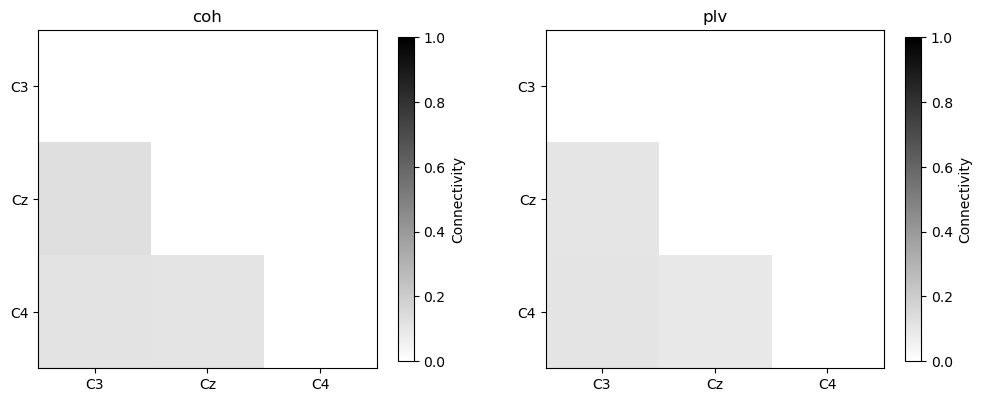

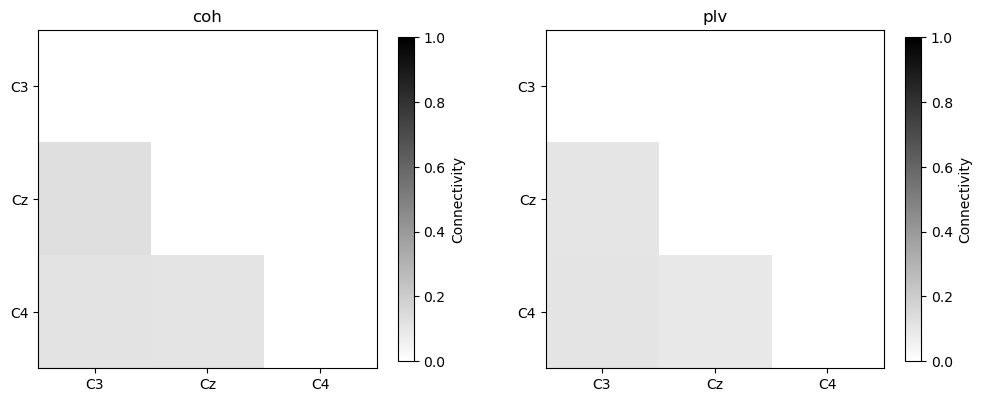

In [6]:
con_time_array = np.mean(con_time_array, axis=1)  # average over epochs
foi = list(Freq_Bands.keys()).index("alpha")  # frequency of interest

plot_con_matrix(con_time_array, n_con_methods)

We see that the connectivity over time are not 1, since the signals were
randomly generated and therefore the phase differences between channels
are also random over time.



**Case 2: 10 Hz sinus waves with different phases.**

In this case, we will generate 10 Hz sinus waves with different phases
for each epoch and each channel. In this case we would expect the
connectivity over time between channels to be 1, but not the connectivity
over trials.



In [7]:
for i in range(n_epochs):  # ensure each epoch are different
    for c in range(n_channels):  # and each channel are also different
        wave_freq = 10  # freq of the sinus wave
        epoch_len = n_times / sfreq
        phase = rng.random(1) * 10  # Introduce random phase for each channel
        # Generate sinus wave
        x = np.linspace(
            -wave_freq * epoch_len * np.pi + phase,
            wave_freq * epoch_len * np.pi + phase,
            n_times,
        )
        data[i, c] = np.squeeze(np.sin(x))  # overwrite to data

data_epoch = mne.EpochsArray(data, info)  # create EpochsArray

# Visualize one epoch to see the phase differences
data_epoch.plot(scalings=1, n_epochs=1)

Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated


First we compute connectivity over trials.



Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 3 connections
    using t=0.000s..7.996s for estimation (2000 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..8.0Hz (17 points)
     band 2: 8.0Hz..13.0Hz (21 points)
     band 3: 13.0Hz..30.0Hz (69 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence, PLV
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3


/tmp/ipykernel_71245/3201707251.py:8: RuntimeWarning: There were no Annotations stored in <EpochsArray |  5 events (all good), 0 – 7.996 s, baseline off, ~242 kB, data loaded,
 '1': 5>, so metadata was not modified.
  con_epochs = spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    assembling connectivity matrix
[Connectivity computation done]
Connectivity method: coh
[[0.         0.         0.        ]
 [0.27435408 0.         0.        ]
 [0.53746866 0.14499043 0.        ]]
Connectivity method: plv
[[0.         0.         0.        ]
 [0.27426325 0.         0.        ]
 [0.53762563 0.14508685 0.        ]]


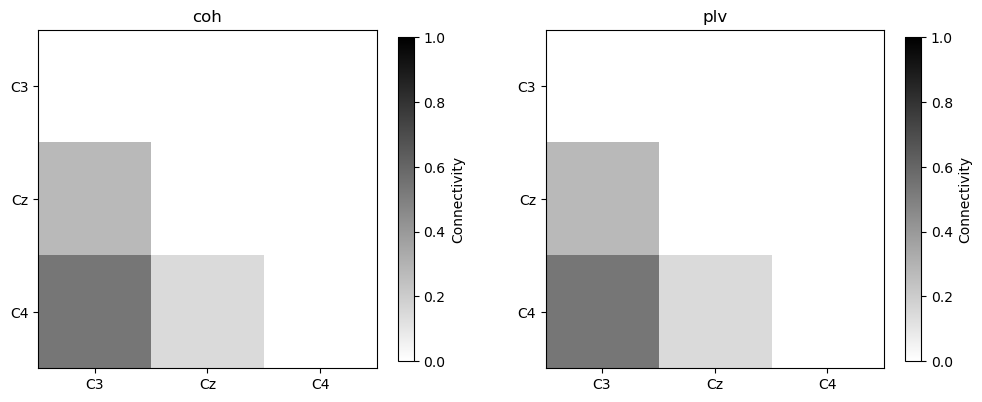

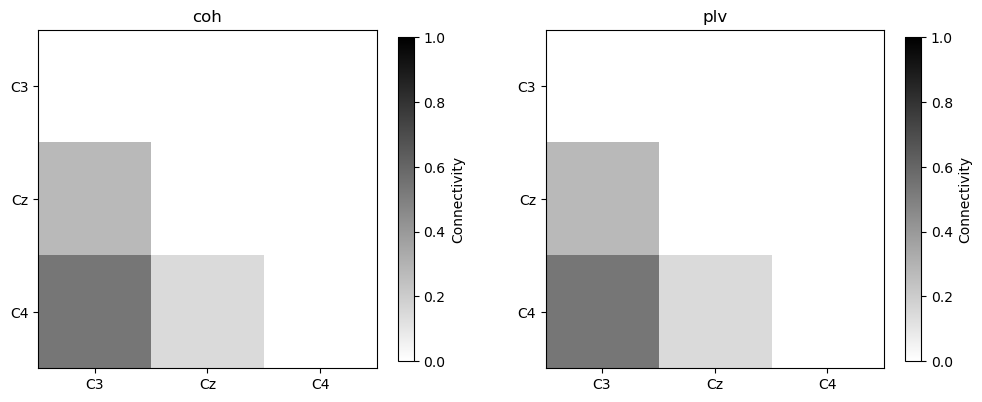

In [8]:
# Pre-allocatate memory for the connectivity matrices
con_epochs_array = np.zeros(
    (n_con_methods, n_channels, n_channels, n_freq_bands, n_times)
)
con_epochs_array[con_epochs_array == 0] = np.nan  # nan matrix

# Compute connecitivty over trials
con_epochs = spectral_connectivity_epochs(
    data_epoch,
    method=connectivity_methods,
    sfreq=sfreq,
    mode="cwt_morlet",
    cwt_freqs=freqs,
    fmin=fmin,
    fmax=fmax,
    faverage=True,
)

# Get data as connectivity matrices
for c in range(n_con_methods):
    con_epochs_array[c] = con_epochs[c].get_data(output="dense")

con_epochs_array = np.mean(con_epochs_array, axis=4)  # average over timepoints

foi = list(Freq_Bands.keys()).index("alpha")  # frequency of interest

plot_con_matrix(con_epochs_array, n_con_methods)

We see that connectivity over trials are not 1, since the phase differences
between two channels are not the same over trials.

We will now compute connectivity over time.



only using indices for lower-triangular matrix
Connectivity computation...
   Processing epoch 1 / 5 ...
   Processing epoch 2 / 5 ...
   Processing epoch 3 / 5 ...


/tmp/ipykernel_71245/1650247729.py:7: RuntimeWarning: There were no Annotations stored in <EpochsArray |  5 events (all good), 0 – 7.996 s, baseline off, ~242 kB, data loaded,
 '1': 5>, so metadata was not modified.
  con_time = spectral_connectivity_time(


   Processing epoch 4 / 5 ...
   Processing epoch 5 / 5 ...
[Connectivity computation done]
Connectivity method: coh
[[0.         0.         0.        ]
 [0.98702769 0.         0.        ]
 [0.99566697 0.9918241  0.        ]]
Connectivity method: plv
[[0.         0.         0.        ]
 [0.99795261 0.         0.        ]
 [0.99918175 0.99879001 0.        ]]


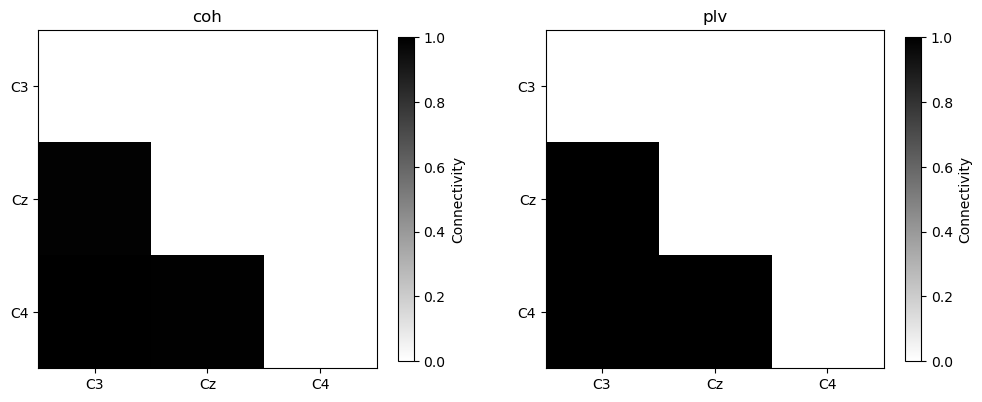

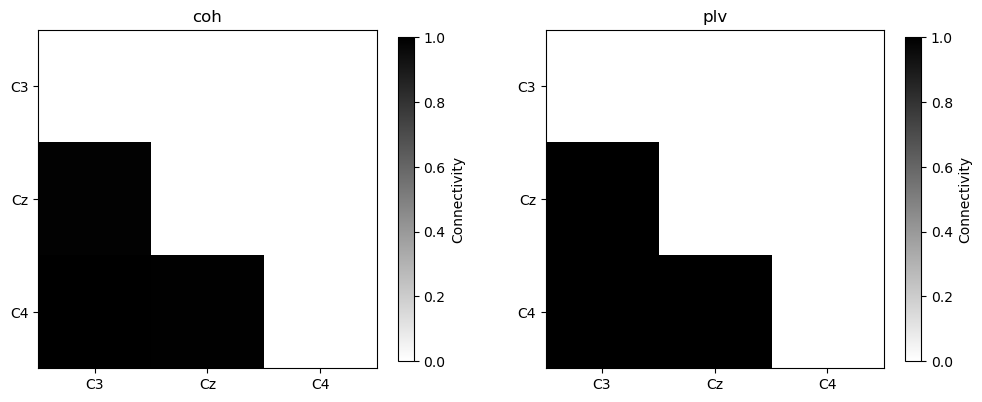

In [9]:
# Pre-allocatate memory for the connectivity matrices
con_time_array = np.zeros(
    (n_con_methods, n_epochs, n_channels, n_channels, n_freq_bands)
)
con_time_array[con_time_array == 0] = np.nan  # nan matrix

con_time = spectral_connectivity_time(
    data_epoch,
    freqs,
    method=connectivity_methods,
    sfreq=sfreq,
    fmin=fmin,
    fmax=fmax,
    faverage=True,
)

# Get data as connectivity matrices
for c in range(n_con_methods):
    con_time_array[c] = con_time[c].get_data(output="dense")

con_time_array = np.mean(con_time_array, axis=1)  # average over epochs
foi = list(Freq_Bands.keys()).index("alpha")  # frequency of interest

plot_con_matrix(con_time_array, n_con_methods)

We see that for case 2, the connectivity over time is approximately 1,
since the phase differences over time between two channels are synchronized.



## Real data demonstration
To finish this example, we will compute connectivity for a sample EEG data.



In [5]:
# Author: Qianliang Li <glia@dtu.dk>
#
# License: BSD (3-clause)

import numpy as np
import matplotlib.pyplot as plt
import mne

from mne_connectivity import spectral_connectivity_epochs, spectral_connectivity_time
from mne_connectivity.viz import plot_sensors_connectivity
from mne.datasets import sample

rng = np.random.default_rng(1234)  # set seed for reproducibility

print(__doc__)

Automatically created module for IPython interactive environment


In [6]:
data_path = sample.data_path()
raw_fname = data_path / "MEG/sample/sample_audvis_filt-0-40_raw.fif"
event_fname = data_path / "MEG/sample/sample_audvis_filt-0-40_raw-eve.fif"
raw = mne.io.read_raw_fif(raw_fname)
events = mne.read_events(event_fname)

# Select only the EEG
picks = mne.pick_types(
    raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads"
)

# Create epochs for left visual field stimulus
event_id, tmin, tmax = 3, -0.3, 1.6
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks, baseline=(None, 0))
epochs.load_data()  # load the data

Opening raw data file /home/wanglab/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Not setting metadata
73 matching events found
Setting baseline interval to [-0.2996928197375818, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
4 projection items activated
Loading data for 73 events and 286 original time points ...
0 bad epochs dropped


Number of events,73
Events,3: 73
Time range,-0.300 – 1.598 s
Baseline,-0.300 – 0.000 s


The sample data consist of repeated trials with a visual stimuli,
thus we use :func:`mne_connectivity.spectral_connectivity_epochs`
to compute connectivity over trials.

Visual tasks are known for evoking event related P1 and N1 responses,
which occurs around 100 and 170 ms after stimuli presentation in
posterior sites. Additionally, increased theta and alpha phase locking
have also been observed during the time window of P1 and
N1 :footcite:`KlimeschEtAl2004`. Here, we will therefore analyze phase
connectivity in the theta band around P1



In [7]:
sfreq = epochs.info["sfreq"]  # the sampling frequency
tmin = 0.0  # exclude the baseline period for connectivity estimation
Freq_Bands = {"theta": [4.0, 8.0]}  # frequency of interest
n_freq_bands = len(Freq_Bands)
min_freq = np.min(list(Freq_Bands.values()))
max_freq = np.max(list(Freq_Bands.values()))

# Prepare the freq points
freqs = np.linspace(min_freq, max_freq, int((max_freq - min_freq) * 4 + 1))

fmin = tuple([list(Freq_Bands.values())[f][0] for f in range(len(Freq_Bands))])
fmax = tuple([list(Freq_Bands.values())[f][1] for f in range(len(Freq_Bands))])

# We specify the connectivity measurements
connectivity_methods = ["wpli"]
n_con_methods = len(connectivity_methods)

# Compute connectivity over trials
con_epochs = spectral_connectivity_epochs(
    epochs,
    method=connectivity_methods,
    sfreq=sfreq,
    mode="cwt_morlet",
    cwt_freqs=freqs,
    fmin=fmin,
    fmax=fmax,
    faverage=True,
    tmin=tmin,
    cwt_n_cycles=4,
)

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1711 connections
    using t=0.000s..1.598s for estimation (241 points)
    frequencies: 4.0Hz..8.0Hz (17 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: WPLI
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12

Notice we have shortened the wavelets to 4 cycles since we only have 1.6s
epochs and are looking at theta activity. This might make the connectivity
measurements more sensitive to noise.



Global theta wPLI peaks 0.080s after stimulus


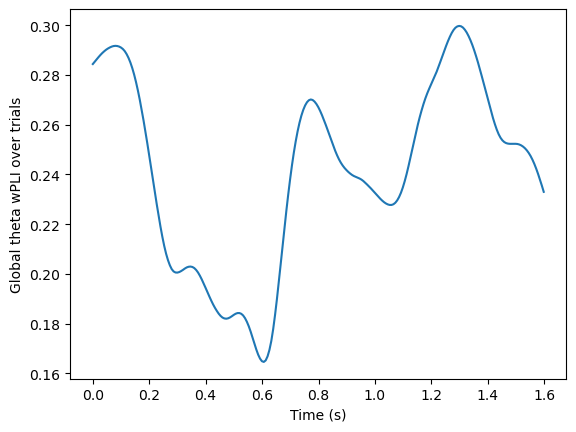

In [8]:
# Plot the global connectivity over time
n_channels = epochs.info["nchan"]  # get number of channels
times = epochs.times[epochs.times >= tmin]  # get the timepoints
n_connections = (n_channels * n_channels - n_channels) / 2

# Get global avg connectivity over all connections
con_epochs_raveled_array = con_epochs.get_data(output="raveled")
global_con_epochs = np.sum(con_epochs_raveled_array, axis=0) / n_connections

# Since there is only one freq band, we choose the first dimension
global_con_epochs = global_con_epochs[0]

fig = plt.figure()
plt.plot(times, global_con_epochs)
plt.xlabel("Time (s)")
plt.ylabel("Global theta wPLI over trials")

# Get the timepoint with highest global connectivity right after stimulus
t_con_max = np.argmax(global_con_epochs[times <= 0.5])
print(f"Global theta wPLI peaks {times[t_con_max]:.3f}s after stimulus")

We see that around the timing of the P1 evoked response, there is high theta
phase coupling on a global scale. To investigate in more details the
individual channels, we visualize the connectivity matrix at the
timepoint with most global theta connectivity after stimulus presentation
and plot the sensor connectivity of the 20 highest connections



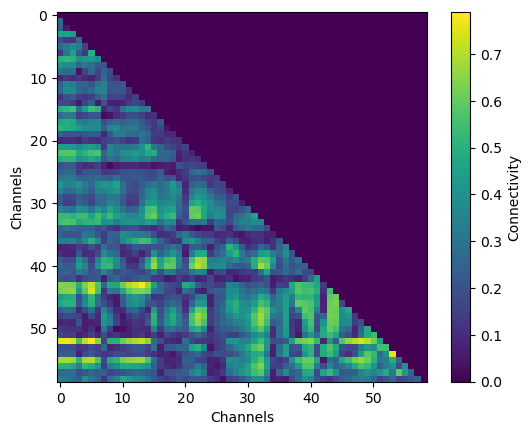

Using pyvistaqt 3d backend.



QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-wanglab'


In [9]:
# Plot the connectivity matrix at the timepoint with highest global wPLI
con_epochs_matrix = con_epochs.get_data(output="dense")[:, :, 0, t_con_max]

fig = plt.figure()
im = plt.imshow(con_epochs_matrix)
fig.colorbar(im, label="Connectivity")
plt.ylabel("Channels")
plt.xlabel("Channels")
plt.show()

# Visualize top 20 connections in 3D
plot_sensors_connectivity(epochs.info, con_epochs_matrix)

## Conclusions
In this example we have looked at the differences between connectivity over
time and connectivity over trials and demonstrated the corresponding
functions implemented in ``mne_connectivity`` on simulated data.

Both functions serve their specific roles, and it's important to use the
correct function for the corresponding task to interpret the analysis.

We also briefly analyzed a visual task EEG sample, using
:func:`mne_connectivity.spectral_connectivity_epochs` where we found that
there was high global theta connectivity around the timepoint of the P1
evoked response. Further analysis revealed the highest connections
at this timepoint were between occipital and frontal areas.




## References
.. footbibliography::

